In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
# Create list of all targets (minus background noise)
# set dataset path
dataset_path = './data_speech_commands_v002'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['nine', 'eight', 'bed', 'bird', 'no', 'house', 'go', 'zero', 'marvin', 'dog', 'off', 'happy', 'stop', 'left', 'two', 'yes', 'on', 'learn', 'three', 'wow', 'tree', 'cat', 'right', 'down', 'six', 'five', 'backward', 'sheila', 'one', 'up', 'follow', 'visual', 'forward', 'seven', 'four']


In [23]:
# Settings
feature_sets_path = './'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_house_model.h5'
wake_word = 'house'

In [4]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [5]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [6]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77497, 16, 16)
(9670, 16, 16)
(9689, 16, 16)


In [7]:
# Peek at labels
print(y_val)

[12. 34. 30. ... 19. 18. 32.]


In [8]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [9]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [10]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.02047569803516029
0.9795243019648397


In [11]:
# View the dimensions of our input data
print(x_train.shape)

(77497, 16, 16)


In [12]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77497, 16, 16, 1)
(9670, 16, 16, 1)
(9689, 16, 16, 1)


In [13]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [14]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [16]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [17]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),)

Epoch 1/30
775/775 [==============================] - 5s 4ms/step - loss: 0.0719 - acc: 0.9810 - val_loss: 0.0388 - val_acc: 0.9888
Epoch 2/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0400 - acc: 0.9879 - val_loss: 0.0408 - val_acc: 0.9897
Epoch 3/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0327 - acc: 0.9909 - val_loss: 0.0290 - val_acc: 0.9915
Epoch 4/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0311 - acc: 0.9912 - val_loss: 0.0389 - val_acc: 0.9909
Epoch 5/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0313 - acc: 0.9918 - val_loss: 0.0543 - val_acc: 0.9870
Epoch 6/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0324 - acc: 0.9919 - val_loss: 0.0442 - val_acc: 0.9917
Epoch 7/30
775/775 [==============================] - 3s 4ms/step - loss: 0.0326 - acc: 0.9918 - val_loss: 0.0527 - val_acc: 0.9913
Epoch 8/30
775/775 [==============================] - 3s 4ms/step - loss: 0.

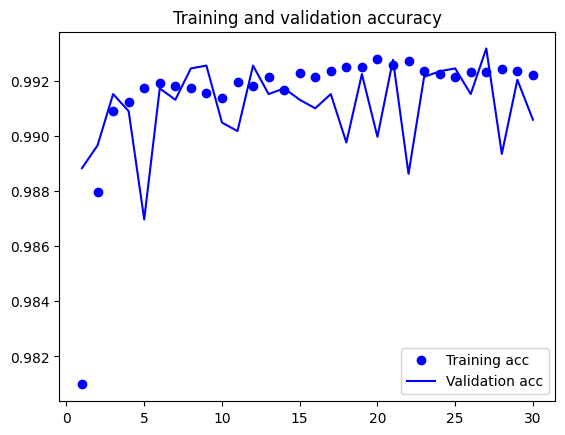

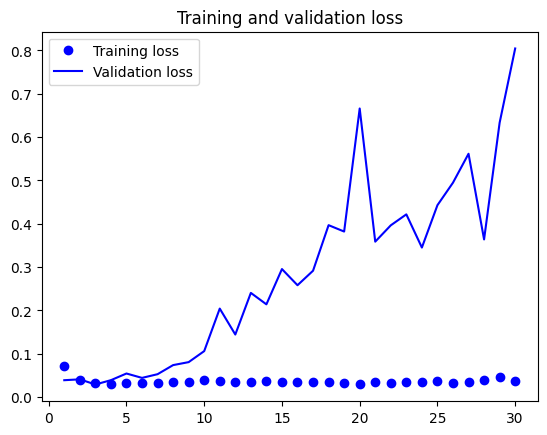

In [18]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# Save the model as a file
models.save_model(model, model_filename)

In [25]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

126
134
142
160
189
194
280
310
348
400
411
420
432
512
524
568
594
633
729
741
792
872
882
899
921
933
968
1007
1090
1150
1176
1194
1249
1341
1396
1397
1409
1461
1505
1597
1636
1639
1652
1890
1900
1949
1988
1994
2016
2060
2098
2104
2289
2300
2304
2380
2395
2437
2487
2511
2615
2673
2773
2793
2885
2923
2936
3029
3099
3308
3423
3439
3457
3464
3615
3708
3753
3978
4037
4055
4066
4098
4156
4225
4234
4299
4326
4328
4399
4430
4444
4574
4603
4610
4626
4640
4743
4881
4904
4906
5038
5052
5123
5183
5275
5385
5392
5437
5450
5571
5768
5809
5835
5839
5854
5878
5902
6023
6149
6209
6236
6238
6239
6294
6299
6314
6369
6376
6461
6517
6567
6583
6598
6669
6746
6782
6877
6891
6956
7010
7110
7437
7492
7507
7592
7606
7687
7727
7745
7880
7919
7981
7986
8071
8197
8200
8208
8223
8269
8272
8456
8632
8699
8812
8846
8854
8857
8989
9155
9191
9293
9327
9390
9452
9569
9627
9643
9686


In [26]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.00833584]]
Answer: 0.0  Prediction: [[2.4518694e-37]]
Answer: 0.0  Prediction: [[1.3164771e-08]]
Answer: 0.0  Prediction: [[0.0050909]]
Answer: 0.0  Prediction: [[7.944579e-13]]
Answer: 0.0  Prediction: [[0.00165166]]
Answer: 0.0  Prediction: [[9.840335e-07]]
Answer: 0.0  Prediction: [[1.2687778e-08]]
Answer: 0.0  Prediction: [[1.6902439e-28]]
Answer: 0.0  Prediction: [[0.00526339]]


In [27]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

303/303 [==============================] - 1s 2ms/step - loss: 0.0418 - acc: 0.9925


[0.04177490621805191, 0.9924656748771667]